# 电线覆冰厚度预测

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import  MLModelPipeline

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

## 数据解析

In [44]:
df = pd.read_csv("./data/process.csv")

In [45]:
df['3h_diff'] = df.groupby('Station_Id_C')['EICED'].diff()
df.dropna(subset=['3h_diff'], inplace=True)

In [46]:
df.drop(columns=['Unnamed: 0', 'Station_Id_C', 'year', 'month', 'day', 'hour', 'Snow_Depth', 'Datetime', 'WEP_WSET'], axis=1, inplace=True)

In [47]:
df.interpolate(inplace=True)

In [48]:
df.columns

Index(['Lat', 'Lon', 'Alti', 'EICED', 'PRS', 'PRS_sea', 'TEM', 'GST_5cm',
       'GST', 'LGST', 'DPT', 'RHU', 'VAP', 'Snow_Depth.1', 'PRE_1h', 'CLO_Cov',
       'WIN_S_Avg_2mi', 'WIN_D_Avg_2mi', 'WEP_Now', 'DICED3h', 'WBT', 'AH',
       'u', 'v', '3h_diff'],
      dtype='object')

In [49]:
df.head()

,Lat,Lon,Alti,EICED,PRS,PRS_sea,TEM,GST_5cm,GST,LGST,...,CLO_Cov,WIN_S_Avg_2mi,WIN_D_Avg_2mi,WEP_Now,DICED3h,WBT,AH,u,v,3h_diff
1,27.1264,111.0064,308.4,0,989.200000,1028.166667,0.500000,3.233333,2.900000,6.166667,...,100.0,0.253557,312.006645,11,-3,0.451335,4.962142,0.188410,-0.169685,-3.0
2,27.1264,111.0064,308.4,0,991.200000,1030.100000,0.366667,3.100000,2.366667,5.700000,...,100.0,1.895731,275.368271,6,0,0.270063,4.867198,1.887417,-0.177359,0.0
3,27.1264,111.0064,308.4,2,990.366667,1029.366667,-0.033333,2.400000,0.800000,5.566667,...,96.0,0.307228,239.601444,1,2,-0.080614,4.783192,0.264993,0.155461,2.0
4,27.1264,111.0064,308.4,0,991.966667,1031.033333,0.366667,2.800000,1.933333,5.666667,...,100.0,0.266667,269.000000,11,-2,0.366667,4.966528,0.266626,0.004654,-2.0
5,27.1264,111.0064,308.4,4,990.566667,1029.566667,0.000000,1.866667,0.566667,4.866667,...,92.0,1.310036,310.689998,6,4,-0.015779,4.826492,0.993332,-0.854099,4.0


## 数据划分

In [50]:
df_scaler = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
# df_scaler[['Lat', 'Lon']] = MinMaxScaler().fit_transform(df[['Lat', 'Lon']])
X, y = df_scaler.drop(['3h_diff'], axis=1).values, df_scaler['3h_diff'].values

In [51]:
X.shape, y.shape

((4234, 24), (4234,))

In [52]:
df_scaler.head()

,Lat,Lon,Alti,EICED,PRS,PRS_sea,TEM,GST_5cm,GST,LGST,...,CLO_Cov,WIN_S_Avg_2mi,WIN_D_Avg_2mi,WEP_Now,DICED3h,WBT,AH,u,v,3h_diff
0,-0.816238,-0.372025,-0.107615,-0.254888,0.034639,-0.891092,1.411908,0.999137,1.705456,3.455951,...,0.727415,-1.352923,1.135363,0.762775,-1.948486,1.571175,1.877241,0.351732,1.011982,-0.938086
1,-0.816238,-0.372025,-0.107615,-0.254888,0.075863,-0.232341,1.324973,0.884848,1.324352,3.206234,...,0.727415,-0.217849,0.876134,-0.403226,-0.034210,1.455380,1.693356,1.714313,1.006996,-0.022279
2,-0.816238,-0.372025,-0.107615,-0.148264,0.058686,-0.482212,1.064167,0.284829,0.204858,3.134886,...,0.586016,-1.315825,0.623071,-1.569226,1.241973,1.231370,1.530656,0.413150,1.223229,0.588259
3,-0.816238,-0.372025,-0.107615,-0.254888,0.091666,0.085677,1.324973,0.627697,1.014705,3.188397,...,0.727415,-1.343862,0.831076,0.762775,-1.310394,1.517090,1.885736,0.414460,1.125250,-0.632817
4,-0.816238,-0.372025,-0.107615,-0.041640,0.062809,-0.414065,1.085901,-0.172328,0.038125,2.760310,...,0.444617,-0.622683,1.126047,-0.403226,2.518157,1.272786,1.614519,0.997269,0.567319,1.198798


In [53]:
# 存储每个模型的交叉验证结果
cv_results = {"model": [], "mse": [], "r2": []}
val_results = {"model": [], "mse": [], "r2": []}
test_results = {"model": [], "mse": [], "r2": []}

In [54]:
def main(model_name, model):
    print(f"\n------ 训练模型: {model_name} ------")
    
    # 创建模型流水线
    pipeline = MLModelPipeline(model=model, model_name=model_name)
    
    # 划分数据集
    X_train, X_val, X_test, y_train, y_val, y_test = pipeline.split_data(X, y)
    
    # 交叉验证
    mse_scores, r2_scores = pipeline.cross_validate_model(X_train, y_train)
    cv_results['model'].append(model_name)
    cv_results['mse'].append(mse_scores.mean())
    cv_results['r2'].append(r2_scores.mean())
    
    print(f"{model_name} 交叉验证MSE: {mse_scores.mean():.4f}, R²: {r2_scores.mean():.4f}")
    
    # 训练模型
    pipeline.train(X_train, y_train)
    
    # 验证集评估
    val_mse, val_r2, val_accuracy = pipeline.evaluate(X_val, y_val)
    val_results['model'].append(model_name)
    val_results['mse'].append(val_mse)
    val_results['r2'].append(val_r2)
    
    print(f"{model_name} 验证集MSE: {val_mse:.4f}, 验证集R²: {val_r2:.4f}, 验证集准确率: {val_accuracy:.4f}")
    
    # 测试集评估
    test_mse, test_r2, test_accuracy = pipeline.test(X_test, y_test)
    test_results['model'].append(model_name)
    test_results['mse'].append(test_mse)
    test_results['r2'].append(test_r2)
    
    print(f"{model_name} 测试集MSE: {test_mse:.4f}, 测试集R²: {test_r2:.4f}, 测试集准确率: {test_accuracy:.4f}")
    # 散点图：测试集上的预测值与实际值
    y_pred_test = pipeline.trained_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"模型 {model_name} 的预测值与实际值对比")
    plt.xlabel("实际值")
    plt.ylabel("预测值")
    plt.show()

In [55]:
# 定义要使用的模型列表
models = {
    # "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    # "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    # "NeuralNetwork": MLPRegressor(hidden_layer_sizes=(40, 20, 10), max_iter=500, random_state=42, activation='relu', ),
    "SVM": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}


------ 训练模型: SVM ------
SVM 交叉验证MSE: 0.2554, R²: 0.3368
SVM 验证集MSE: 3.3876, 验证集R²: 0.0821, 验证集准确率: 0.0796
SVM 测试集MSE: 0.7600, 测试集R²: 0.0938, 测试集准确率: 0.1027


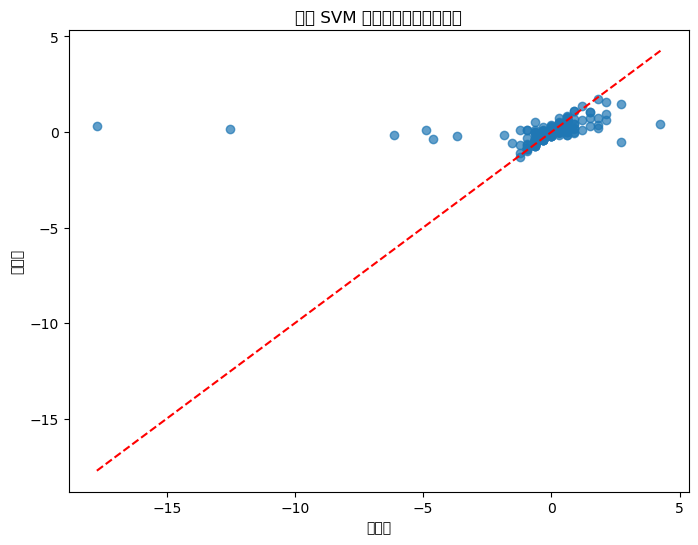

In [56]:
for k, v in models.items():
    main(k, v)